# To Do
* fix pyvista to work on remote server
    * use pvxarray for plotting topographies in 3D
* use rioxarray.pad_box or xarray.pad for padding
* use rioxarray.reproject_match for resampling
* use vd.median_distance for constraints grid construction
* replace pygmt.grd2xyz with vd.grid_to_table  

* use vd.Trend.jacobian for regularization
* use vd.base.least_squares for optimization

* use vd.Trend to remove region
* test prism_layer difference if input .nc grids are pixel registered instead of gridline registered
* add actual grav observation elevations
* check bedmap1 riggs points are reference to geoid

* use discretize package to increase grid spacing outside of inv_reg
* implement vertically increasing density to both ice and sediment (like harmonica.tesseroid_gravity)

In [1]:
# The standard Python science stack
import numpy as np
import pandas as pd
import scipy as sp
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# geoscience packages
import pygmt
import pyproj
import pyvista as pv
import geopandas as gpd
import harmonica as hm
import verde as vd
import xarray as xr
from tqdm import tqdm
import rioxarray
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', message="pandas.Int64Index")
warnings.filterwarnings('ignore', message="pandas.Float64Index")
# from scripts.gravbox import * 
# from scripts.grav_column_der import grav_column_der

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio
wave = np.sin(2*np.pi*400*np.arange(10000*1)/10000)
notify = Audio(wave, rate=10000, autoplay=True)

import os 
os.getcwd()
%load_ext snakeviz

# Functions

In [32]:
def plot_grd(
        grid, 
        cmap : str, 
        cbar_label : str, 
        plot_region=None, 
        cmap_region=None, 
        coast=False,
        constraints=False,
        grd2cpt_name=False, 
        origin_shift='initialize',
        ):
    global fig, projection
    if plot_region is None:
        plot_region = inv_reg
    if cmap_region is None:
        cmap_region = inv_reg
    if plot_region == buffer_reg:
        projection = buffer_proj
    elif plot_region == inv_reg:
        projection = inv_proj
    # initialize figure or shift for new subplot
    if origin_shift=='initialize':
        fig = pygmt.Figure()   
    elif origin_shift=='xshift':
        fig.shift_origin(xshift=(fig_width + 2)/10)
    elif origin_shift=='yshift':
        fig.shift_origin(yshift=(fig_height + 12)/10)

    # set cmap
    if grd2cpt_name:
        pygmt.grd2cpt(
            cmap=cmap, 
            grid=grid, 
            region=cmap_region, 
            background=True, 
            continuous=True,
            output=f'plotting/{grd2cpt_name}.cpt')
        cmap = f'plotting/{grd2cpt_name}.cpt'

    fig.grdimage(
        grid=grid,
        cmap=cmap,
        projection=projection, 
        region=plot_region,
        nan_transparent=True,
        frame=['+gwhite'])

    fig.colorbar(
        cmap=cmap, 
        position='jBC+jTC+h', 
        frame=f'x+l"{cbar_label}"')

    if coast==True:
        fig.plot(
                projection = projection, 
                region = plot_region,
                data = gpd.read_file('plotting/GroundingLine_Antarctica_v02.shp'), 
                pen = '1.2p,black', 
                verbose='q',)

    fig.plot(data = gpd.read_file('plotting/Coastline_Antarctica_v02.shp'), 
            pen = '1.2p,black',
            verbose='q',
            )
    if constraints==True:
        fig.plot(
                x = constraints_RIS_df.x, 
                y = constraints_RIS_df.y, 
                style = 'c1.2p',
                color = 'black',
                projection = projection,
                region = plot_region,)

    if plot_region==buffer_reg:
        fig.plot(
            x = [inv_reg[0], inv_reg[0], inv_reg[1], inv_reg[1], inv_reg[0]], 
            y = [inv_reg[2], inv_reg[3], inv_reg[3], inv_reg[2], inv_reg[2]], 
            pen = '2p,black', 
            projection = projection,
            region = plot_region,)

def import_layers(
            layers_list, 
            spacing_list, 
            rho_list, 
            fname_list,
            grav_spacing, 
            active_layer,
            plot_region=None,
            # grav_file='gravity_data/ant4d_gravity_epsg_5k.nc',
            grav_file='gravity_data/rosetta_grav.nc',
            constraints=False,
            constraints_file='constraints_grid/constraints_grid.nc',
            constraints_points='bathymetry_data/bedmachine_RIGGS.csv',
            plot=True,
            plot_type='xarray'):
    global inv_reg, grid_grav, layers, df_grav
    if constraints==True:
        global constraints_grid, constraints_df, constraints_RIS_df
    if plot_region==None:
        plot_region=inv_reg

    # read and resample gravity grid
    filt_grav = pygmt.grdfilter(
                        grid=grav_file,
                        filter=f'g{grav_spacing}', 
                        distance='0',
                        nans='r', # retains NaNs
                        )
    filt_grav_fill = pygmt.grdfilter(
                        grid=grav_file,
                        filter=f'g{grav_spacing}', 
                        distance='0',
                        )
    # grid_grav = vd.grid_to_table(grid_grav).dropna(subset='Gobs').set_index(['x','y']).to_xarray()
    grid_grav = pygmt.grdsample(
                        grid=filt_grav,
                        region=inv_reg, 
                        registration='p', 
                        spacing=grav_spacing,
                        ).to_dataset(name='Gobs')                 
    grid_grav['Gobs_fill'] = pygmt.grdsample(
                        grid=filt_grav_fill,
                        region=inv_reg, 
                        registration='p', 
                        spacing=grav_spacing,
                        )#.to_dataset(name='Gobs_fill') 
    
    # center on 0
    grid_grav['Gobs'] -= grid_grav.Gobs.mean().item()
    grid_grav['Gobs_fill'] -= grid_grav.Gobs_fill.mean().item()
                        
    # df_grav = grid_grav.to_dataframe().reset_index()
    # df_grav.rename(columns={'z':'Gobs'}, inplace=True)
    # df_grav.dropna(how='any', inplace=True)  

    # make nested dictionary for layers and properties
    layers = {j:{'spacing':spacing_list[i], 
            'fname':fname_list[i], 
            'rho':rho_list[i]} for i, j in enumerate(layers_list)}

    # read and resample layer grids, convert to dataframes
    for k, v in layers.items():
        v['grid'] = pygmt.grdfilter(
                        grid=v['fname'],
                        region=buffer_reg, 
                        registration='p', 
                        spacing=v['spacing'],
                        filter=f"g{v['spacing']}", 
                        distance='0'
                        )#.rename({'x':'easting', 'y':'northing'})           
        # v['grid'] = pygmt.grdsample(
        #                 grid=v['fname'],
        #                 region=buffer_reg, 
        #                 registration='p', 
        #                 spacing=v['spacing'],
        #                 # verbose='e',
        #                 )
        v['df'] = v['grid'].to_dataframe().reset_index()
        v['df']['rho']=v['rho']
        v['df'].dropna(how='any', inplace=True)
        v['len']=len(v['df'].x) 

    # add gravity elevation (approximated as 750m above top layer (surface)
    # df_grav['z'] = pygmt.grdtrack(points = df_grav[['x','y']], 
    #             grid = layers[layers_list[0]]['grid'], 
    #             newcolname = 'z').z + 750
    grid_grav['z'] = pygmt.grdtrack(points = vd.grid_to_table(grid_grav)[['x','y']], 
                grid = layers[layers_list[0]]['grid'],
                newcolname='z').set_index(['x','y']).to_xarray().z   
    # df_grav['z']=750

    if constraints==True:
        # read and resample constraints grid, and mask outside of RIS
        constraints_grid = pygmt.grdsample(
                            grid=constraints_file,
                            region=buffer_reg, 
                            registration='p', 
                            spacing=spacing_list[layers_list.index(active_layer)],
                            # verbose='e',
                            )
        fname = 'bathymetry_data/bedmachine_RIGGS.csv'
        constraints_df =  pd.read_csv(fname, index_col=False)
        buffer_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
        !gmt grdmask plotting/MEaSUREs_RIS.shp -Gplotting/RIS_GL_mask_outer.nc -I1000 -R{buffer_reg_str} -NNaN/NaN/1
        constraints_RIS_df = pygmt.select(data=constraints_df, gridmask='plotting/RIS_GL_mask_outer.nc')

    # print lengths
    for k, v in layers.items():
        print(f"{k}: {v['len']} points, elevations: {int(np.nanmax(v['grid']))}m to {int(np.nanmin(v['grid']))}m") 
    print(f'gravity: {len(vd.grid_to_table(grid_grav.Gobs))} points')    
    if constraints==True:
        print(f'bathymetry control points:{len(constraints_df)}') 

    if plot==True:
        if plot_type=='pygmt':
            # get max and min of all layer grids
            # max_list=[]
            # min_list=[]
            # for i, (k, v) in enumerate(layers.items()):
            #     max_list.append(np.nanmax(v['grid']))
            #     min_list.append(np.nanmin(v['grid']))
            # pygmt.makecpt(cmap='earth+h0', series=[np.min(min_list)*.5, np.max(max_list)*.2], output='plotting/layer.cpt')
            plot_grd(
                grid = grid_grav.Gobs, 
                plot_region=inv_reg, 
                cmap = "jet",
                grd2cpt_name = 'grav',
                cbar_label = "observed gravity (mGal)", 
                constraints = constraints,    
                )

            for i, (k, v) in enumerate(layers.items()):
                plot_grd(
                    grid=layers[k]['grid'], 
                    plot_region=inv_reg, 
                    # cmap = "plotting/layer.cpt",
                    cmap='viridis',
                    grd2cpt_name = 'elevations',
                    cbar_label = f"{k} elevation (m)",
                    origin_shift='xshift',
                    )
            fig.show(width=1200)
        elif plot_type=='xarray':

            fig, ax = plt.subplots(ncols=len(layers)+1, nrows=1, figsize=(20,20))#, constrained_layout=True)
            grid_grav.Gobs.plot(ax=ax[0], robust=True, cmap='RdBu_r', 
                cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
            ax[0].set_title('Observed gravity')
            for i, j in enumerate(layers):
                if plot_region==buffer_reg:
                    grid = layers[j]['grid']
                elif plot_region==inv_reg:    
                    grid = layers[j]['grid'].rio.set_spatial_dims(
                                    'x', 'y').rio.write_crs("epsg:3031").rio.clip_box(
                                        minx=inv_reg[0], maxx=inv_reg[1], 
                                        miny=inv_reg[2], maxy=inv_reg[3])
                grid.plot(ax=ax[i+1], robust=True, cmap='gist_earth',
                    cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})
                ax[i+1].set_title(f'{j} elevation')
            for a in ax:
                a.set_xticklabels([])
                a.set_yticklabels([])
                a.set_xlabel('')
                a.set_ylabel('')
                a.set_aspect('equal')

def grids_to_prism_layers(
    layers, 
    plot_layers=None, 
    plot_region=None, 
    plot=False, 
    plot_type='3D',
    clip_cube=True
    ):
    global reversed_layers_list

    if plot_region is None:
        plot_region = inv_reg
    if plot_layers is None:
        plot_layers = layers_list[:-1]

    # add density variable to datasets
    for k, v in layers.items():
        v['grid']['density']=v['grid'].copy()
        v['grid'].density.values[:] = v['rho']

    # list of layers, bottom up
    reversed_layers_list = layers_list.iloc[::-1]

    # create prisms layers from input grids
    for i, j in enumerate(reversed_layers_list):
        if i == 0:
            layers[j]['prisms']=hm.prism_layer(
                coordinates=(layers[j]['grid'].x.values, layers[j]['grid'].y.values),    
                surface=layers[j]['grid'], 
                reference=-50e3,
                # reference = np.nanmin(layers[j]['grid'].values)*2, # bottom of prisms is twice the deepest depth
                properties={'density':layers[j]['grid'].density})
            print(f'{j} top: {int(np.nanmean(layers[j]["prisms"].top.values))}m and bottom: {int(np.nanmean(layers[j]["prisms"].bottom.values))}m')
        else:
            # if spacing of layer doesn't match below layer's spacing, sample lower layer to get values for bottoms of prisms.
            if layers[j]['spacing'] != layers[reversed_layers_list.iloc[i-1]]['spacing']:
                print(f"resolutions don't match for {j} ({layers[j]['spacing']}m) and {reversed_layers_list.iloc[i-1]} ({layers[reversed_layers_list.iloc[i-1]]['spacing']}m)")
                print(f"sampling {reversed_layers_list.iloc[i-1]} at {j} prism locations")
                tmp = layers[j]['grid'].to_dataframe().reset_index()
                tmp_regrid = pygmt.grdtrack(points = tmp[['x','y']], 
                                            grid = layers[reversed_layers_list.iloc[i-1]]['grid'], 
                                            newcolname = 'z_regrid')
                tmp['z_low']=tmp.merge(tmp_regrid, how = 'left', on = ['x','y']).z_regrid
                tmp_grd = pygmt.xyz2grd(tmp[['x','y','z_low']], region = buffer_reg, registration='p', spacing = layers[j]['spacing'])

                layers[j]['prisms']=hm.prism_layer(
                    coordinates=(layers[j]['grid'].x.values, layers[j]['grid'].y.values),   
                    surface=layers[j]['grid'], 
                    reference=tmp_grd,
                    properties={'density':layers[j]['grid'].density})
                print(f'{j} top: {int(np.nanmean(layers[j]["prisms"].top.values))}m and bottom: {int(np.nanmean(layers[j]["prisms"].bottom.values))}m')
            else:
                layers[j]['prisms']=hm.prism_layer(
                    coordinates=(layers[j]['grid'].x.values, layers[j]['grid'].y.values),   
                    surface=layers[j]['grid'], 
                    reference=layers[reversed_layers_list.iloc[i-1]]['grid'],
                    properties={'density':layers[j]['grid'].density})
                print(f'{j} top: {int(np.nanmean(layers[j]["prisms"].top.values))}m and bottom: {int(np.nanmean(layers[j]["prisms"].bottom.values))}m')
    
    if plot == True:
        if plot_type=='3D':
            # plot prisms layers in 3D with pyvista
            plotter = pv.Plotter(lighting="three_lights", window_size=(5000, 5000))
            colors = ['lavender','aqua','goldenrod','saddlebrown','black']
            for i, j in enumerate(plot_layers):
                if plot_region==buffer_reg:
                    prisms  = layers[j]['prisms']
                else:
                    prisms = layers[j]['prisms'].rio.set_spatial_dims(
                                'easting', 'northing').rio.write_crs("epsg:3031").rio.clip_box(
                                    minx=inv_reg[0], maxx=inv_reg[1], 
                                    miny=inv_reg[2], maxy=inv_reg[3])
                layers[j]['pvprisms'] = prisms.prism_layer.to_pyvista()
                if clip_cube == True:
                    # to clip out a cube
                    bounds = [
                        inv_reg[0], inv_reg[0]+((inv_reg[1]-inv_reg[0])/2),
                        inv_reg[2], inv_reg[2]+((inv_reg[3]-inv_reg[2])/2), 
                        -50e3, 1e3]
                    layers[j]['pvprisms'] = layers[j]['pvprisms'].clip_box(bounds, invert=True)
                plotter.add_mesh(
                    layers[j]['pvprisms'], color=colors[i], #scalars="density", cmap='viridis', flip_scalars=True,
                    # smooth_shading=True, style='points', point_size=2, show_edges=False, # for just plotting surfaces
                    smooth_shading=True, style='surface', show_edges=False,# for 3D blocks
                )  
            plotter.set_scale(zscale=20)  # exaggerate the vertical coordinate
            plotter.camera_position = "xz"
            plotter.camera.elevation = 20
            plotter.camera.azimuth = -25
            plotter.camera.zoom(1)
            plotter.show_axes()
            plotter.show()
        elif plot_type=='thickness':
            for i, j in enumerate(layers):
                if i == 0:
                    fig, ax = plt.subplots(ncols=len(layers), nrows=1, figsize=(20,20))
                thick = (layers[j]['prisms'].top - layers[j]['prisms'].bottom)
                if plot_region==buffer_reg:
                    thick.plot(ax=ax[i], robust=True, cmap='viridis',
                        cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})
                    ax[i].set_title(f'{j} prism thickness')
                elif plot_region==inv_reg:
                    thick = thick.rio.set_spatial_dims(
                                 'easting', 'northing').rio.write_crs("epsg:3031").rio.clip_box(
                                     minx=inv_reg[0], maxx=inv_reg[1], 
                                     miny=inv_reg[2], maxy=inv_reg[3])
                    thick.plot(ax=ax[i], robust=True, cmap='viridis',
                        cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})
                    ax[i].set_title(f'{j} prism thickness')
            for a in ax:
                a.set_xticklabels([])
                a.set_yticklabels([])
                a.set_xlabel('')
                a.set_ylabel('')
                a.set_aspect('equal')

def forward_grav_layers(layers, exclude_layers, plot=True, plot_type='pygmt'):
    include_forward_layers = layers_list[~layers_list.isin(exclude_layers)]
    
    # Calculate inital forward gravity model of input layers
    df_grav = vd.grid_to_table(grid_grav)

    for k, v in layers.items():
        df_grav[f"{k}_forward_grav"] = v['prisms'].prism_layer.gravity(
            coordinates = (df_grav.x, df_grav.y, df_grav.z), 
            field = 'g_z')
        grid_grav[k] = df_grav.set_index(['x','y']).to_xarray()[f"{k}_forward_grav"]
        grid_grav[k] -= grid_grav[k].mean().item()
        print(f'finished {k} layer')

    # add gravity effects of all input layers
    grid_grav['forward_total'] = sum(d for d in grid_grav[include_forward_layers.values].data_vars.values())

    if plot==True:
        if plot_type=='pygmt':
            plot_grd(
                # plot_region=buffer_reg,
                grid=grid_grav.forward_total,
                cmap='jet',
                grd2cpt_name='grav',
                cbar_label = f"combined forward gravity (mGal)",)

            for i, j in enumerate(include_forward_layers):
                plot_grd(
                    # plot_region=buffer_reg,
                    grid=grid_grav[j],
                    cmap = 'jet',
                    grd2cpt_name = 'grav',
                    cbar_label = f"{j} forward gravity (mGal)",
                    origin_shift='xshift',)
            fig.show(width=1200) 
        elif plot_type=='xarray':
            fig, ax = plt.subplots(ncols=len(include_forward_layers)+1, nrows=1, figsize=(20,20))
            grid_grav.forward_total.plot(ax=ax[0], x='x', y='y', robust=True, cmap='RdBu_r', 
                cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
            ax[0].set_title('Total forward gravity')
            for i, j in enumerate(include_forward_layers):
                grid_grav[j].plot(ax=ax[i+1], x='x', y='y', robust=True, cmap='RdBu_r',
                    cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})
                ax[i+1].set_title(f'{j} forward gravity')
            for a in ax:
                a.set_xticklabels([])
                a.set_yticklabels([])
                a.set_xlabel('')
                a.set_ylabel('')
                a.set_aspect('equal')

def anomalies(
    layers, 
    input_grav,
    input_grav_column,
    regional_method,
    corrections = None,
    filter='g200e3', 
    trend_order=2,
    plot=True,
    plot_type='xarray',
    constraints=False,
    ): 
    gravity = input_grav[input_grav_column].copy() 

    # remove forward grav of some layers
    for i, j in enumerate(corrections):
        gravity -= input_grav[j]

    input_grav['misfit'] = gravity - input_grav.forward_total
    # fill nans for vd.Trend
    # input_grav['misfit_filled'].rio.write_crs("epsg:3031").interpolate_na() #.rio.set_spatial_dims('x', 'y').
    grid_grav.misfit.to_netcdf('tmp.nc')
    grid_grav['misfit_filled'] = pygmt.grdfill('tmp.nc', mode='n')

    if constraints==True:
        # sample Gobs_misfit at constraint points
        tmp_regrid = pygmt.grdtrack(points = constraints_RIS_df[['x','y']], 
                                    grid = input_grav.Gobs_misfit, newcolname = 'Gmisfit_sampled')
        constraints_RIS_df['Gmisfit']=constraints_RIS_df.merge(tmp_regrid, how = 'left', on = ['x','y']).Gmisfit_sampled
        shift = constraints_RIS_df.Gmisfit.mean()
        # df_grav['initial_misfit'] = df_grav.Gobs - df_grav.forward_grav_total
        # shift = df_grav.initial_misfit.mean() 
        # print(f'Shift value: initial misfit at control points is {int(shift)} mGal')
    else:
        pass
        # shift = input_grav.Gobs_misfit.mean(skipna=True).item()
        # print(f'Shift value: initial misfit everywhere {int(shift)} mGal')
    df_grav = vd.grid_to_table(input_grav).astype(np.float64)
    if regional_method=='filter':
        input_grav['regional_misfit'] = pygmt.grdfilter(
                    input_grav.misfit, filter=filter, distance='0')
        df_grav['reg'] =  vd.grid_to_table(input_grav.regional_misfit).regional_misfit           
        input_grav['residual_misfit'] = input_grav.misfit - input_grav.regional_misfit
        df_grav['res'] =  vd.grid_to_table(input_grav.residual_misfit).residual_misfit
    elif regional_method=='trend':
        
        trend = vd.Trend(degree=trend_order).fit((df_grav.x,df_grav.y), df_grav.misfit_filled)
        df_grav['reg'] = trend.predict((df_grav.x,df_grav.y))
        df_grav['res'] = df_grav.misfit - df_grav.reg
        input_grav['regional_misfit'] = df_grav.set_index(['x','y']).to_xarray().reg
        input_grav['residual_misfit'] = df_grav.set_index(['x','y']).to_xarray().res
    
    if plot==True:
        if plot_type=='pygmt':
            grid = grid_grav.Gobs_shift
            plot_grd(grid=grid, cmap='jet', grd2cpt_name='grav',
                cbar_label = "observed gravity (mGal)",)

            grid = grid_grav.Gobs_shift_filt
            plot_grd(grid=grid, cmap='plotting/grav.cpt', #grd2cpt_name='grav',
                cbar_label = "filtered observed gravity (mGal)", origin_shift='xshift',)

            grid = grid_grav.forward_total
            plot_grd(grid=grid, cmap='plotting/grav.cpt', #grd2cpt_name='grav',
                cbar_label = "forward gravity (mGal)", origin_shift='xshift',)

            grid = grid_grav.misfit
            plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='grav',
                cbar_label = "gravity misfit (mGal)", origin_shift='xshift',)

            grid = grid_grav.misfit_filt
            plot_grd(grid=grid, cmap='plotting/grav.cpt',
                cbar_label = "regional gravity misfit (mGal)", origin_shift='xshift',)
            fig.show(width=1200) 

        elif plot_type=='xarray':
            fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(20,20))
            
            grid = gravity
            grid.plot(ax=ax[0], x='x', y='y', robust=True, cmap='RdBu_r', 
                cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
            ax[0].set_title('observed gravity')
            
            grid = input_grav.forward_total
            grid.plot(ax=ax[1], x='x', y='y', robust=True, cmap='RdBu_r', 
                cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
            ax[1].set_title('forward gravity')

            grid = input_grav.misfit
            grid.plot(ax=ax[2], x='x', y='y', robust=True, cmap='RdBu_r', 
                cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
            ax[2].set_title('gravity misfit')

            grid = input_grav.regional_misfit
            grid.plot(ax=ax[3], x='x', y='y', robust=True, cmap='RdBu_r', 
                cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
            ax[3].set_title('regional misfit')

            grid = input_grav.residual_misfit
            grid.plot(ax=ax[4], x='x', y='y', robust=True, cmap='RdBu_r', 
                cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
            ax[4].set_title('residual misfit')

            for a in ax:
                a.set_xticklabels([])
                a.set_yticklabels([])
                a.set_xlabel('')
                a.set_ylabel('')
                a.set_aspect('equal')                
    return df_grav.dropna(subset='res')

def density_inversion(density_layer, max_density_change=2000,  input_grav=None, plot=True):    
    if input_grav is None:
        input_grav=df_grav.Gobs_shift_filt
    # density in kg/m3
    forward_grav_layers(layers=layers, plot=False)
    spacing = layers[density_layer]['spacing']

    # df_grav['inv_misfit']=df_grav.Gobs_shift-df_grav[f'forward_grav_total']
    df_grav['inv_misfit']=input_grav - df_grav[f'forward_grav_total']

    # get prisms' coordinates from active layer
    prisms = layers[density_layer]['prisms'].to_dataframe().reset_index().dropna()

    print(f'active layer average density: {int(prisms.density.mean())}kg/m3')

    MAT_DENS = (np.zeros([len(input_grav),len(prisms)]))

    initial_RMS = round(np.sqrt((df_grav['inv_misfit'] **2).mean()),2)
    print(f"initial RMS = {initial_RMS}mGal")
    print('calculating sensitivity matrix to determine density correction')

    prisms_n=[]
    for x in range(len(layers[density_layer]['prisms'].easting.values)):
        for y in range(len(layers[density_layer]['prisms'].northing.values)):
            prisms_n.append(layers[density_layer]['prisms'].prism_layer.get_prism((x,y)))
    for col, prism in enumerate(prisms_n):
        MAT_DENS[:, col] = hm.prism_gravity(
            coordinates = (df_grav.x, df_grav.y, df_grav.z),
            prisms = prism,
            density = 1, # unit density
            field = 'g_z',)
    # Calculate shift to prism's densities to minimize misfit     
    Density_correction=lsqr(MAT_DENS,df_grav.inv_misfit,show=False)[0]

    # for i,j in enumerate((input_grav)): #add tqdm for progressbar
    #         MAT_DENS[i,:] = gravbox(
    #                             df_grav.y.iloc[i], df_grav.x.iloc[i], df_grav.z.iloc[i],
    #                             prisms.northing-spacing/2, prisms.northing+spacing/2,
    #                             prisms.easting-spacing/2, prisms.easting+spacing/2,
    #                             prisms.top,  prisms.bottom, np.ones_like(prisms.density))  # unit density, list of ones
    # # Calculate shift to prism's densities to minimize misfit     
    # Density_correction=lsqr(MAT_DENS,df_grav.inv_misfit,show=False)[0]*1000

    # apply max density change
    for i in range(0,len(prisms)):
        if Density_correction[i] > max_density_change:
            Density_correction[i]=max_density_change
        elif Density_correction[i] < -max_density_change:
            Density_correction[i]=-max_density_change

    # resetting the rho values with the above correction
    prisms['density_correction']=Density_correction
    prisms['updated_density']=prisms.density+prisms.density_correction
    dens_correction = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=prisms.density_correction, registration='p', 
                    region=buffer_reg, spacing=grav_spacing, projection=buffer_proj)
    dens_update = pygmt.xyz2grd(x=prisms.easting, y=prisms.northing, z=prisms.updated_density, registration='p', 
                    region=buffer_reg, spacing=layers[density_layer]['spacing'], projection=buffer_proj)
    initial_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing, registration='p')

    # apply the rho correction to the prism layer
    layers[density_layer]['prisms']['density'].values=dens_update.values
    print(f"average density: {int(layers[density_layer]['prisms'].to_dataframe().reset_index().dropna().density.mean())}kg/m3")
    # recalculate forward gravity of active layer               
    print('calculating updated forward gravity')
    df_grav[f'forward_grav_{density_layer}'] = layers[density_layer]['prisms'].prism_layer.gravity(
            coordinates=(df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')

    # Recalculate of gravity misfit, i.e., the difference between calculated and observed gravity
    df_grav['forward_grav_total'] = df_grav.forward_grav_total - \
                                    df_grav[f'{density_layer}_forward_grav'] + \
                                    df_grav[f'forward_grav_{density_layer}']
                                    
    df_grav.inv_misfit = input_grav - df_grav.forward_grav_total
    final_RMS = round(np.sqrt((df_grav.inv_misfit **2).mean()),2)
    print(f"RMSE after inversion = {final_RMS}mGal")
    final_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=buffer_reg, registration='p', spacing=grav_spacing)

    if plot==True:
        grid = initial_misfit
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='misfit',
            cbar_label = f"initial misfit (mGal) [{initial_RMS}]")

        grid = dens_correction
        plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='dens_corr',
            cbar_label = "density correction (kg/m3)", origin_shift='xshift')

        grid = dens_update
        plot_grd(grid=grid, cmap='viridis', grd2cpt_name='dens_update',
            cbar_label = "updated density (kg/m3)", origin_shift='xshift')

        grid = final_misfit
        plot_grd(grid=grid, cmap='polar+h0',# grd2cpt_name='misfit',
            cbar_label = f"final misfit (mGal) [{final_RMS}]", origin_shift='xshift')

        fig.show(width=1200)

def grav_column_der(x0,y0,z0,xc,yc,z1,z2,res,rho):
    r=np.sqrt((x0-xc)**2+(y0-yc)**2)
    r1=r-0.5*res 
    r2=r+0.5*res   
    r1[r1<0]=0 # will fail if prism is under obs point
    r2[r1<0]=0.5*res
    f=res**2/(np.pi*(r2**2-r1**2)) #eq 2.19 in McCubbine 2016 Thesis
    anomaly_grad=0.0419*f*rho*(z1-z0)*(1/np.sqrt(r2**2+(z1-z0)**2)-1/np.sqrt(r1**2+(z1-z0)**2))
    return anomaly_grad

def jacobian_annular(gravity_data, gravity_col, prisms, spacing):
    """
    Calculation of the Jacobian matrix using the annular cylinder approximation
    jacobian is matrix array with NG number of rows and NBath+NBase+NM number of columns
    uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
    """
    df = vd.grid_to_table(gravity_data).dropna(subset=gravity_col)
    jac = np.empty((len(df[gravity_col]), len(prisms)), dtype=np.float64)
    for i,j in enumerate((df[gravity_col])):
            jac[i,:] = grav_column_der(
                df.y.iloc[i], # coords of gravity observation points
                df.x.iloc[i],
                df.z.iloc[i],  
                prisms.northing, prisms.easting,     
                prisms.top, 
                prisms.bottom,
                spacing,     
                prisms.density/1000)
    return jac

def jacobian_prism(gravity_data, gravity_col, model, delta, field):
    """
    Calculation of the Jacobian matrix with the vertical gravity derivative 
    as a numerical approximation with small prisms 
    """
    df = vd.grid_to_table(gravity_data).dropna(subset=gravity_col)
    jac = np.empty((len(df[gravity_col]), model.top.size), dtype=np.float64)
    # Build a generator for prisms (doesn't allocate memory,only returns at request)
    prisms_n_density = ( 
        (model.prism_layer.get_prism((i, j)), model.density.values[i, j])
        for i in range(model.northing.size)
        for j in range(model.easting.size)
    )
    for col, (prism,density) in enumerate(prisms_n_density):
        # Build a small prism ontop of existing prism (thickness equal to delta)
        bottom = prism[5] - delta / 2
        top = prism[5] + delta / 2
        delta_prism = (prism[0], prism[1], prism[2], prism[3], bottom, top)
        jac[:,col] = hm.prism_gravity(
            coordinates=(df.x, df.y, df.z),
            prisms=delta_prism, 
            density=density, 
            field=field
            ) / delta 
    return jac
    # for x in range(len(layers[density_layer]['prisms'].easting.values)):
    #     for y in range(len(layers[density_layer]['prisms'].northing.values)):
    #         prisms_n.append(layers[density_layer]['prisms'].prism_layer.get_prism((x,y)))
    # for col, prism in enumerate(prisms_n):
    #     MAT_DENS[:, col] = hm.prism_gravity(
    #         coordinates = (df_grav.x, df_grav.y, df_grav.z),
    #         prisms = prism,
    #         density = 1, # unit density
    #         field = 'g_z',)

def geo_inversion(
    active_layer,
    exclude_layers,
    layers, 
    input_grav,
    input_grav_column,
    regional_method,
    filter='g200e3', 
    trend_order=2,
    plot=True,
    plot_type='xarray',
    reset=True,
    constraints=False, 
    misfit_sq_tolerance=0.00001,
    delta_misfit_squared_tolerance=0.002,
    Max_Iterations=5,
    deriv_type = 'annulus',
    max_layer_change_per_iter=100, #meters
    ): 

    include_forward_layers = layers_list[~layers_list.isin(exclude_layers)]

    if reset is True:
        grids_to_prism_layers(layers, plot=False)
        forward_grav_layers(layers, exclude_layers=exclude_layers, plot=False)
    
    spacing = layers[active_layer]['spacing'] 
    misfit_squared_updated=np.Inf  # positive infinity
    delta_misfit_squared=np.Inf  # positive infinity
    ind = include_forward_layers[include_forward_layers == active_layer].index[0]
    ITER=0
    # while delta_misfit_squared (inf) is greater than 1 + least squares tolerance (0.02)
    while delta_misfit_squared > 1+delta_misfit_squared_tolerance:
        ITER+=1 
        print(f"##################################\n iteration {ITER}")
        df_grav = anomalies(layers, input_grav, input_grav_column, 
            corrections=exclude_layers, regional_method=regional_method, 
            filter=filter, trend_order=trend_order, plot=False)

        # df_grav.dropna(subset='res', inplace=True)

        initial_RMS = round(np.sqrt((df_grav.res**2).mean(skipna=True)),2)
        print(f"initial RMS = {initial_RMS}mGal")

        # get prisms' coordinates from active layer and layer above
        prisms = layers[active_layer]['prisms'].to_dataframe().reset_index().dropna()
        prisms_above = layers[include_forward_layers[ind-1]]['prisms'].to_dataframe().reset_index().dropna()

        # calculate jacobian
        if deriv_type == 'annulus':
            jac = jacobian_annular(input_grav, input_grav_column, prisms, spacing)
        elif deriv_type == 'prisms':
            jac = jacobian_prism(input_grav, input_grav_column, layers[active_layer]['prisms'], 1, "g_z")
        else:
            print('not valid derivative type')  

        # Calculate shift to prism's tops to minimize misfit
        # gives the amount that each column's Z1 needs to change by to have the smallest misfit
        Surface_correction=lsqr(jac, df_grav.res.values, show=False)[0] # finds the least-squares solution to jacobian and Grav_Misfit, assigns the first value to Surface_correction

        # if necessary correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
        for i in range(0,len(prisms)):
            if Surface_correction[i] > max_layer_change_per_iter:
                Surface_correction[i]=max_layer_change_per_iter
            elif Surface_correction[i] < -max_layer_change_per_iter:
                Surface_correction[i]=-max_layer_change_per_iter
        prisms['surface_correction']=Surface_correction
        prisms_above['surface_correction']=Surface_correction

        # apply above surface corrections 
        if constraints==True:
            # add constraints to dataframe
            prisms['constraints']=constraints_grid.to_dataframe().reset_index().z
            prisms_above['constraints']=constraints_grid.to_dataframe().reset_index().z
            prisms.top += prisms.surface_correction * prisms.constraints
            prisms_above.bottom += prisms_above.surface_correction * prisms_above.constraints
        else:
            print('constraints not applied')
            prisms.top += prisms.surface_correction
            prisms_above.bottom += prisms_above.surface_correction

        # apply the z correction to the active prism layer and the above layer with Harmonica 
        prisms_grid = pygmt.xyz2grd(prisms[['easting','northing','top']],region=buffer_reg, registration='p', spacing=spacing)
        prisms_above_grid = pygmt.xyz2grd(prisms_above[['easting','northing','bottom']], region=buffer_reg, registration='p', spacing=spacing)
        layers[active_layer]['prisms'].prism_layer.update_top_bottom(
                        surface = prisms_grid, 
                        reference = layers[active_layer]['prisms'].bottom)
        layers[include_forward_layers[ind-1]]['prisms'].prism_layer.update_top_bottom(
                        surface = layers[include_forward_layers[ind-1]]['prisms'].top, 
                        reference = prisms_above_grid)

        input_grav['initial_misfit'] = df_grav.set_index(['x','y']).to_xarray().res
        
        # add .to_xarray to replace below
        iter_corr = pygmt.xyz2grd(
            x=prisms.easting,y=prisms.northing, z=prisms.surface_correction, region=buffer_reg, registration='p', spacing=spacing)
        if constraints==True:
            iter_corr_constrained = pygmt.xyz2grd(
                x=prisms.easting,y=prisms.northing, z=prisms.surface_correction*prisms.constraints, region=buffer_reg, registration='p', spacing=spacing)
        
        print('calculating updated forward gravity')
        df_grav[active_layer] = layers[active_layer]['prisms'].prism_layer.gravity(
            coordinates=(df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')
        input_grav[active_layer]=df_grav.set_index(['x','y']).to_xarray()[active_layer] 
        
        df_grav[include_forward_layers[ind-1]] = layers[include_forward_layers[ind-1]]['prisms'].prism_layer.gravity(
            coordinates=(df_grav.x, df_grav.y, df_grav.z),
            field = 'g_z')
        input_grav[include_forward_layers[ind-1]]=df_grav.set_index(['x','y']).to_xarray()[include_forward_layers[ind-1]] 
        
        grav_layers_list = [f'{i}' for i in include_forward_layers]
        df_grav['forward_total']=df_grav[grav_layers_list].sum(axis=1, skipna=True)
        
        # update the forward gravity grid
        input_grav['forward_total']=df_grav[['x','y','forward_total']].set_index(['x','y']).to_xarray().forward_total
        
        # update the misfit grid
        # input_grav['inv_misfit'] = input_grav[input_grav_column] - input_grav.forward_total
        df_grav = anomalies(layers, input_grav, input_grav_column, 
            corrections=exclude_layers, regional_method=regional_method, 
            filter=filter, trend_order=trend_order, plot=False)
        input_grav['inv_misfit'] = df_grav.set_index(['x','y']).to_xarray().res 

        final_RMS = round(np.sqrt((input_grav.inv_misfit **2).mean(skipna=True).item()),2)
        print(f"RMSE after iteration {ITER} = {final_RMS}mGal")
        # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to delta_misfit_squared_tolerance (0.02)
        misfit_sq=(input_grav.inv_misfit**2).mean(skipna=True).item()
        delta_misfit_squared=misfit_squared_updated/misfit_sq
        misfit_squared_updated=misfit_sq # updated 
        layers[active_layer]['inv_grid']=pygmt.xyz2grd(prisms[['easting','northing','top']], region=buffer_reg, registration='p', spacing=spacing)
        
        # final_Gfor = pygmt.xyz2grd(df_grav[['x','y','forward_total']], region=buffer_reg, registration='p', spacing=grav_spacing)
        # final_misfit = pygmt.xyz2grd(df_grav[['x','y','inv_misfit']], region=buffer_reg, registration='p', spacing=grav_spacing)
        difference = layers[active_layer]['inv_grid'] - layers[active_layer]['grid']

        if plot==True:
            if plot_type=='pygmt':
                grid = initial_misfit
                if ITER ==1:
                    plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='misfit',
                        cbar_label = f"initial misfit (mGal) [{initial_RMS}]", origin_shift='initialize')
                else:
                    plot_grd(grid=grid, cmap='plotting/misfit.cpt',
                        cbar_label = f"initial misfit (mGal) [{initial_RMS}]", origin_shift='yshift')

                grid=layers[active_layer]['inv_grid']
                plot_grd(grid=grid, cmap='globe',
                    cbar_label = "updated bathymetry (m)", origin_shift='xshift')

                grid = iter_corr
                if ITER == 1:
                    plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='corr',
                        cbar_label = "iteration correction (m)", origin_shift='xshift')
                else:
                    plot_grd(grid=grid, cmap='plotting/corr.cpt',
                        cbar_label = "iteration correction (m)", origin_shift='xshift')

                grid = difference 
                if ITER ==1:
                    plot_grd(grid=grid, cmap='polar+h0', grd2cpt_name='diff',
                        cbar_label = f"total {active_layer} difference (m)", origin_shift='xshift')
                else:
                    plot_grd(grid=grid, cmap='plotting/diff.cpt',
                        cbar_label = f"total {active_layer} difference (m)", origin_shift='xshift')

                grid = input_grav.inv_misfit
                plot_grd(grid=grid, cmap='plotting/misfit.cpt',
                    cbar_label = f"final gravity misfit (mGal) [{final_RMS}]", origin_shift='xshift')
            
                # plot iteration label
                fig.shift_origin(xshift=((fig_width)/10))
                fig.text(projection = projection, 
                    position='ML',
                    justify='ML',
                    text = f"It. #{ITER}",
                    font = '30p,Helvetica,black',
                    clearance = '+tO')
                fig.shift_origin(xshift=-((fig_width)/10))
                
                # shift back to origin 
                fig.shift_origin(xshift=-4*((fig_width + 2)/10))
    
            elif plot_type=='xarray':
                nrow = Max_Iterations
                ncol = 5
                height = 5
                width = height * (input_grav.z.shape[0]/input_grav.z.shape[1])
                grid1 = input_grav.initial_misfit
                grid2 = layers[active_layer]['inv_grid'].rio.set_spatial_dims(
                                    'x', 'y').rio.write_crs("epsg:3031").rio.clip_box(
                                        minx=inv_reg[0], maxx=inv_reg[1], 
                                        miny=inv_reg[2], maxy=inv_reg[3])
                grid3 = iter_corr.rio.set_spatial_dims(
                                    'x', 'y').rio.write_crs("epsg:3031").rio.clip_box(
                                        minx=inv_reg[0], maxx=inv_reg[1], 
                                        miny=inv_reg[2], maxy=inv_reg[3])
                grid4 = difference.rio.set_spatial_dims(
                                    'x', 'y').rio.write_crs("epsg:3031").rio.clip_box(
                                        minx=inv_reg[0], maxx=inv_reg[1], 
                                        miny=inv_reg[2], maxy=inv_reg[3])
                grid5 = input_grav.inv_misfit

                if ITER==1:
                    fig = plt.figure(figsize=(width*ncol, height*nrow)) 
                    gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1]*ncol,
                                            wspace=0.1, hspace=0, 
                                            top=0.95, bottom=0.05, 
                                            left=0.17, right=0.845)
                    misfit_lims = (-vd.maxabs(grid1)*.9, 
                                    vd.maxabs(grid1)*.9)
                    topo_lims = (grid2.min(skipna=True).item()*.9,
                                 grid2.max(skipna=True).item()*.9)
                    corr_lims = (-vd.maxabs(grid3), 
                                  vd.maxabs(grid3))
                    diff_lims = (-vd.maxabs(grid4)*1.5, 
                                  vd.maxabs(grid4)*1.5)
            
                p=0
                
                ax = plt.subplot(gs[ITER-1,p])
                plt.text(-0.1, 0.5, f'Iteration #{ITER}',
                        transform=ax.transAxes,
                        rotation='vertical',
                        ha='center',
                        va='center',
                        fontsize=20,
                        )
                grid1.plot(ax=ax, x='x', y='y', vmin=misfit_lims[0], vmax=misfit_lims[1],
                    cmap='RdBu_r', add_labels=False,
                    cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_title(f'initial misfit: {initial_RMS}mGal')
                p+=1

                ax = plt.subplot(gs[ITER-1,p])
                grid2.plot(ax=ax, x='x', y='y', vmin=topo_lims[0], vmax=topo_lims[1],
                    cmap='gist_earth', add_labels=False, 
                    cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
                ax.set_xticklabels([])
                ax.set_yticklabels([])                
                ax.set_title('updated bathymetry')
                p+=1

                ax = plt.subplot(gs[ITER-1,p])
                grid3.plot(ax=ax, x='x', y='y', vmin=corr_lims[0], vmax=corr_lims[1],
                    cmap='RdBu_r', add_labels=False,
                    cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_title('iteration correction')
                p+=1

                ax = plt.subplot(gs[ITER-1,p])
                grid4.plot(ax=ax, x='x', y='y', vmin=diff_lims[0], vmax=diff_lims[1],
                    cmap='RdBu_r', add_labels=False,
                    cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_title(f'total {active_layer} difference')
                p+=1

                ax = plt.subplot(gs[ITER-1,p])
                grid5.plot(ax=ax, x='x', y='y', vmin=misfit_lims[0], vmax=misfit_lims[1],
                    cmap='RdBu_r', add_labels=False,
                    cbar_kwargs={'orientation':'horizontal', 'anchor':(1,1.8)})  
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.set_title(f'final gravity misfit: {final_RMS}mGal')

        if plot_type=='pygmt':
            fig.show(width=1200)     

        if ITER == Max_Iterations:
            print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because maximum number of iterations ({Max_Iterations}) reached")
            break
        if misfit_sq < misfit_sq_tolerance:
            print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because least-squares norm < {misfit_sq_tolerance}")
            break
        
    # end of inversion iteration WHILE loop
    if delta_misfit_squared < 1+delta_misfit_squared_tolerance:
        print("terminated - no significant variation in least-squares norm ")

In [3]:
zoom = 0e3
n_shift = 0e3#600e3
w_shift = 0#250e3
buffer = 300e3

# starting region is 1,000km x 1,000km
e_inv = -580000+zoom+w_shift
w_inv = 420000-zoom+w_shift
n_inv = -1420000+zoom-n_shift
s_inv = -420000-zoom-n_shift

inv_reg = [e_inv, w_inv, n_inv, s_inv]
e_buff, w_buff, n_buff, s_buff = int(e_inv-buffer), int(w_inv+buffer), int(n_inv-buffer), int(s_inv+buffer)
buffer_reg = [e_buff, w_buff, n_buff, s_buff]
buffer_reg_str=f'{e_buff}/{w_buff}/{n_buff}/{s_buff}'
inv_reg_ll = "-180/180/-90/-71"

fig_height = 80
fig_width = fig_height*(w_inv-e_inv)/(s_inv-n_inv)

inv_ratio = (s_inv-n_inv)/(fig_height/1000)
buffer_ratio = (s_buff-n_buff)/(fig_height/1000)

inv_proj = f"x1:{inv_ratio}"
buffer_proj = f"x1:{buffer_ratio}"

inv_proj_ll = f"s0/-90/-71/1:{inv_ratio}"
buffer_proj_ll = f"s0/-90/-71/1:{buffer_ratio}"

layers_list = pd.Series([
             'ice',
             'water',
             'bathymetry',
            #  'basement',
            #  'moho'
])

spacing_list = pd.Series([
                20e3,
                20e3,
                20e3,
                # 10e3,
                # 10e3
])

rho_list = pd.Series([
            920, #890 to 917 from Muto et al. 2013
            1030, #from Muto et al. 2013
            2300,
            # 2670,
            # 3300
])

grav_spacing = 20e3

active_layer='bathymetry'

fname_list = pd.Series([
        # SURFACE 
            'inversion_layers/bedmachine/BedMachine_surface_filled.nc',
        # ICEBASE
            'inversion_layers/bedmachine/BedMachine_icebase_filled.nc',
        # BED/BATHYMETRY
            # 'bathymetry_data/bedmap_bedmachine_RIGGS_grd_fill.nc',
            # 'bathymetry_data/bedmap2_bed_regional.nc',
            'inversion_layers/bedmachine/BedMachine_bed.nc',
        # BASEMENT
            # 'inversion_layers/ANTASed_mag_basement_filled.nc',
            # 'inversion_layers/RE_basement_BedMachinebed_filled.nc',
            # 'inversion_layers/lindeque_basement.nc',
        # MOHO
            # 'inversion_layers/An_moho_filt.nc'
            # 'inversion_layers/Shen_moho.nc',
            # 'inversion_layers/Pappa_moho.nc'
])

# forward_layers = {k:v for k,v in layers.items() if k not in ['ice']}

#  Import layers

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


ice: 6400 points, elevations: 3460m to 0m
water: 6400 points, elevations: 3458m to -2250m
bathymetry: 6400 points, elevations: 3458m to -4229m
gravity: 2500 points


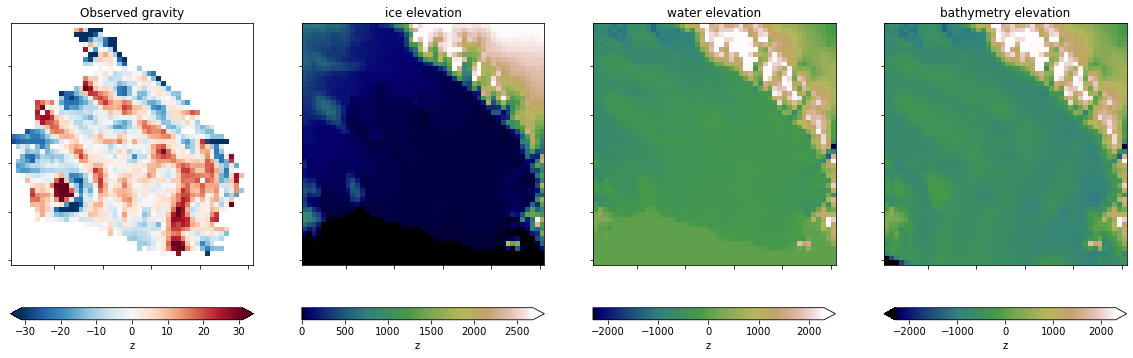

In [4]:
import_layers(
    layers_list, 
    spacing_list, 
    rho_list, 
    fname_list,
    grav_spacing, 
    active_layer,
    constraints=False,
    plot=True,
    plot_region=inv_reg,
    plot_type='xarray')

# Make prism layers

In [5]:
grids_to_prism_layers(layers, plot=False, plot_type='thickness', plot_region=inv_reg)

bathymetry top: -379m and bottom: -50000m
water top: 30m and bottom: -379m
ice top: 1006m and bottom: 30m


# Forward gravity

finished ice layer
finished water layer
finished bathymetry layer


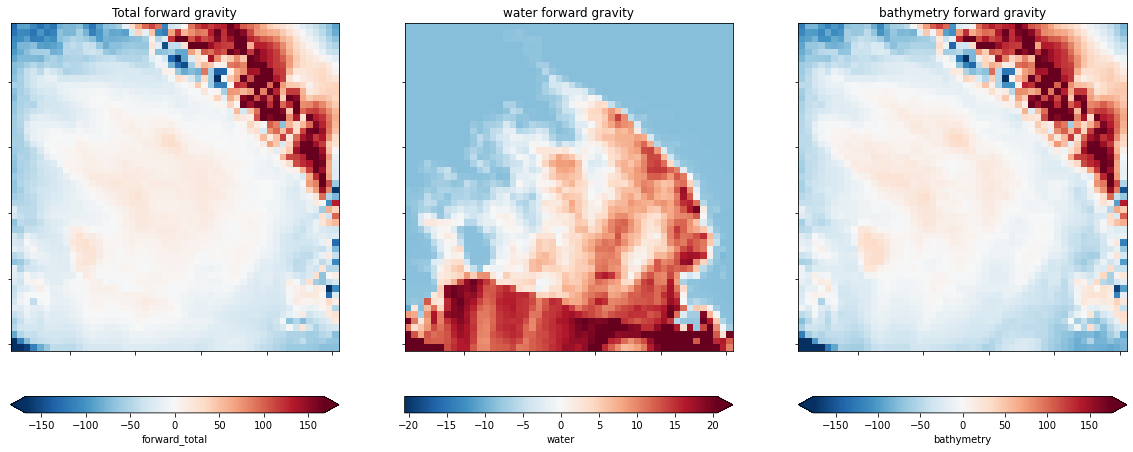

In [6]:
forward_grav_layers(layers, exclude_layers=['ice'], plot=True, plot_type='xarray') #layers_list[layers_list!='ice']

# Anomalies

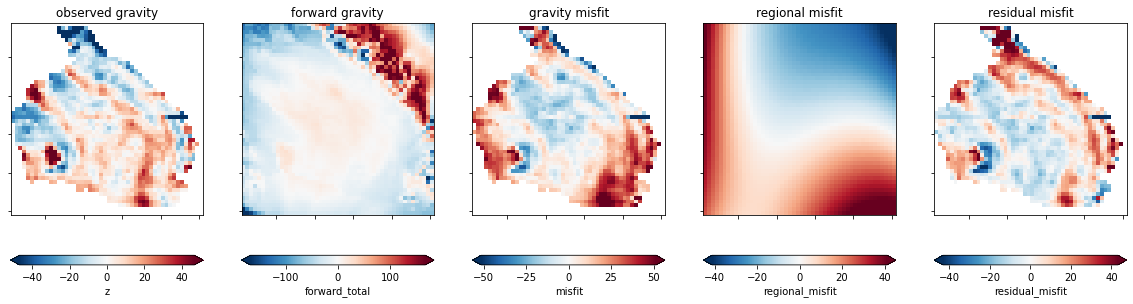

In [33]:
residual = anomalies(layers, grid_grav, 'Gobs_fill', corrections=['ice'], 
          regional_method='trend', filter='g200e3', trend_order=3,
          plot=True, plot_type='xarray')


# Geo inversion

bathymetry top: -379m and bottom: -50000m
water top: 30m and bottom: -379m
ice top: 1006m and bottom: 30m
finished ice layer
finished water layer
finished bathymetry layer
##################################
 iteration 1
initial RMS = 16.74mGal
constraints not applied
calculating updated forward gravity
RMSE after iteration 1 = 12.49mGal
##################################
 iteration 2
initial RMS = 12.49mGal
constraints not applied
calculating updated forward gravity
RMSE after iteration 2 = 9.87mGal
Inversion terminated after 2 iterations with least-squares norm=97 because maximum number of iterations (2) reached


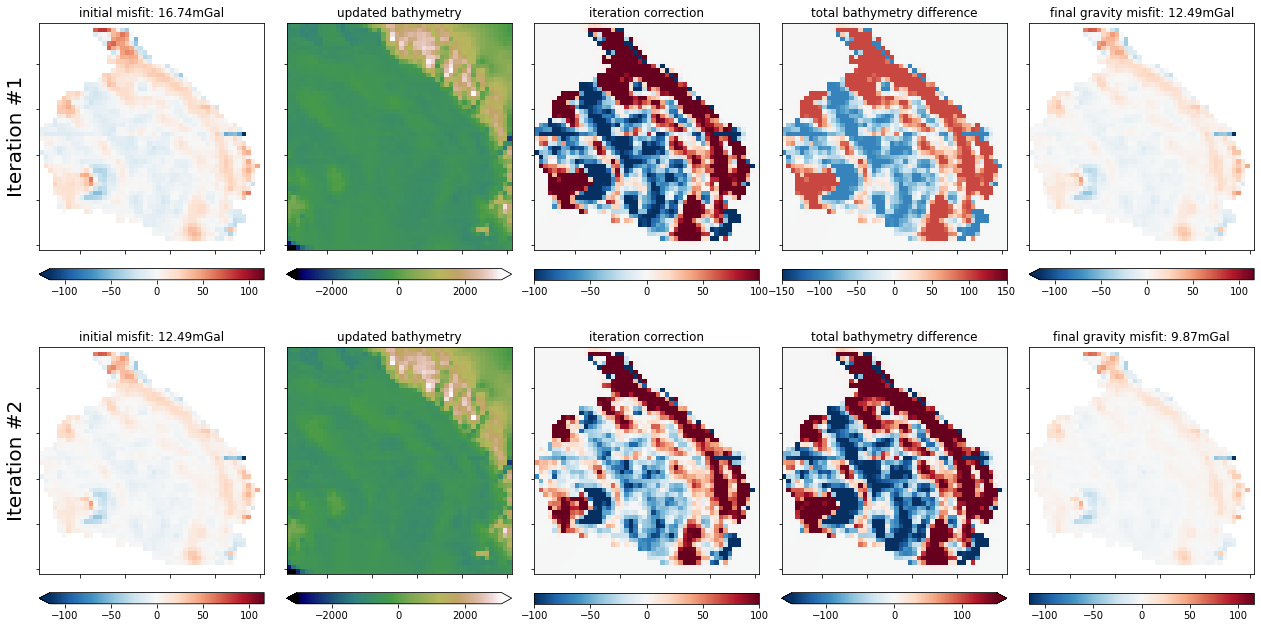

In [34]:
# %%snakeviz -t
geo_inversion(
    active_layer='bathymetry',
    exclude_layers=['ice'],
    layers=layers, 
    input_grav=grid_grav, 
    input_grav_column='Gobs_fill',
    regional_method='trend',
    filter='g200e3', 
    trend_order=3,
    deriv_type='annulus',
    reset=True,
    constraints=False,
    Max_Iterations=2,
    max_layer_change_per_iter=100,
    misfit_sq_tolerance=0.00001,
    delta_misfit_squared_tolerance=0.002,
    plot=True,
    plot_type='xarray'
    ) 
# 15 mins 200km zoom/5k, 7mins 400kmzoom/5k (113x113 prisms, 33x33 grav)
# 1:54s for annulus
# 1:46s for prisms
# notify

# Density inversion

In [ ]:
# density_inversion(density_layer='bathymetry', plot=True) #10mins, 200km zoom/5k, 3.5mins 400km zoom/5k (113x113 prisms, 33x33 grav)
# notify